<a href="https://colab.research.google.com/github/shashank08-spec/Ds-project/blob/main/DSS_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Size Class / Cause Interpretation using US Wildfire Data (SQLite)

This notebook uses the `FPA_FOD_20170508.sqlite` database (Kaggle “1.88 Million US Wildfires”)
and trains a machine learning model on the `Fires` table.

Main steps:

1. Load data from SQLite (`Fires` table)
2. Select and explore key columns
3. Feature engineering (dates, seasons, geo clusters)
4. Pre-processing and encoding
5. Train/test split and SMOTE balancing
6. XGBoost training with hyperparameter tuning
7. Model evaluation
8. Save model and encoders
9. **Enhanced inference** with:
   - Input preprocessing
   - Safe encoding
   - Area burned in acres & hectares
   - Human-readable class interpretation




Imports & Config

In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


Connect to SQLite & List Tables

In [4]:
DB_PATH = "/content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/data/FPA_FOD_20170508.sqlite"

conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
conn.close()

tables


,name
0,spatial_ref_sys
1,spatialite_history
2,sqlite_sequence
3,geometry_columns
4,spatial_ref_sys_aux
5,views_geometry_columns
6,virts_geometry_columns
7,geometry_columns_statistics
8,views_geometry_columns_statistics
9,virts_geometry_columns_statistics


No charts were generated by quickchart


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Fires Table

In [5]:
conn = sqlite3.connect(DB_PATH)
df_raw = pd.read_sql_query("SELECT * FROM Fires;", conn)
conn.close()

print("Raw Fires table shape:", df_raw.shape)
df_raw.head()
df = df_raw.copy()

Raw Fires table shape: (1880465, 39)


Exploring Data

--- Missing Values Check ---
LOCAL_FIRE_REPORT_ID       1459286
LOCAL_INCIDENT_ID           820821
FIRE_CODE                  1555636
FIRE_NAME                   957189
ICS_209_INCIDENT_NUMBER    1854748
ICS_209_NAME               1854748
MTBS_ID                    1869462
MTBS_FIRE_NAME             1869462
COMPLEX_NAME               1875282
DISCOVERY_TIME              882638
CONT_DATE                   891531
CONT_DOY                    891531
CONT_TIME                   972173
COUNTY                      678148
FIPS_CODE                   678148
FIPS_NAME                   678148
dtype: int64

--- Distribution of Wildfire Causes ---
STAT_CAUSE_DESCR
Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Stru

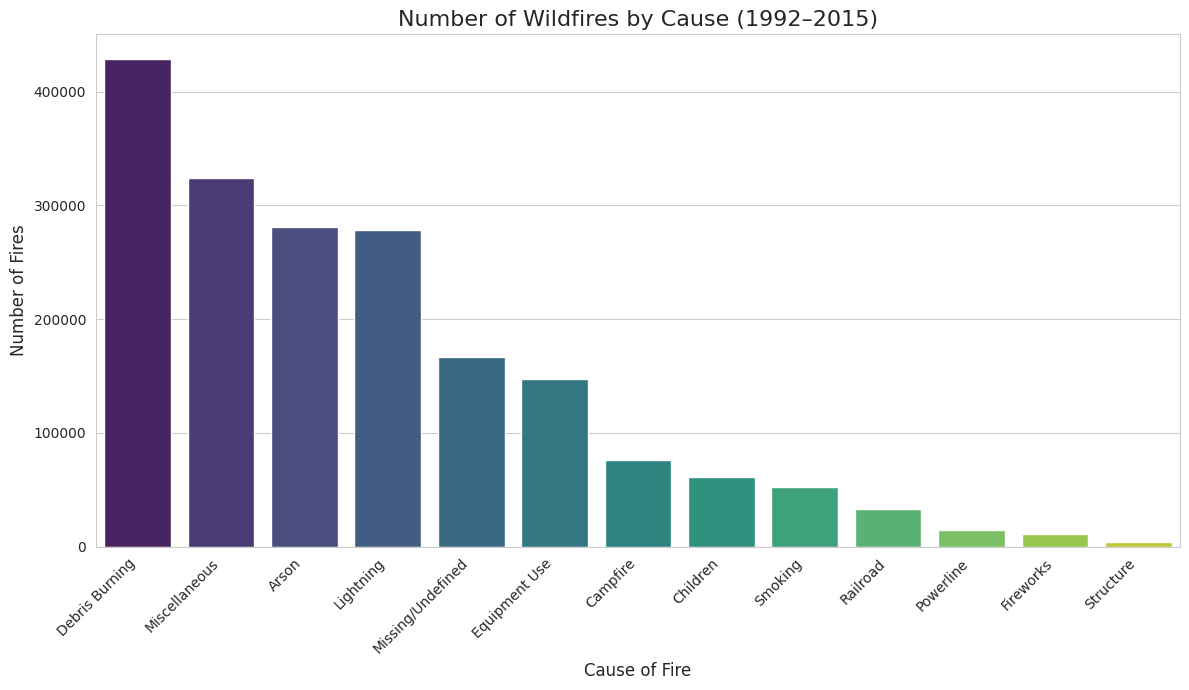

In [6]:
# --- Exploring Wildfire Cause Distribution ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set_style("whitegrid")

# --- Check for Missing Values ---
print("--- Missing Values Check ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the selected columns. Great!")

# --- Explore Target Variable (STAT_CAUSE_DESCR) ---
print("\n--- Distribution of Wildfire Causes ---")

if "STAT_CAUSE_DESCR" not in df.columns:
    raise ValueError("STAT_CAUSE_DESCR column is missing from df!")

cause_counts = df["STAT_CAUSE_DESCR"].value_counts()
print(cause_counts)

# --- Plot Wildfire Causes ---
plt.figure(figsize=(12, 7))
sns.barplot(
    x=cause_counts.index,
    y=cause_counts.values,
    palette="viridis",
    hue=cause_counts.index,
    legend=False
)

plt.title("Number of Wildfires by Cause (1992–2015)", fontsize=16)
plt.xlabel("Cause of Fire", fontsize=12)
plt.ylabel("Number of Fires", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Extracting Months

--- Correct 'DATETIME' and 'MONTH' Features Created ---


,DISCOVERY_DATETIME,MONTH
0,2005-02-02,2
1,2004-05-12,5
2,2004-05-31,5
3,2004-06-28,6
4,2004-06-28,6


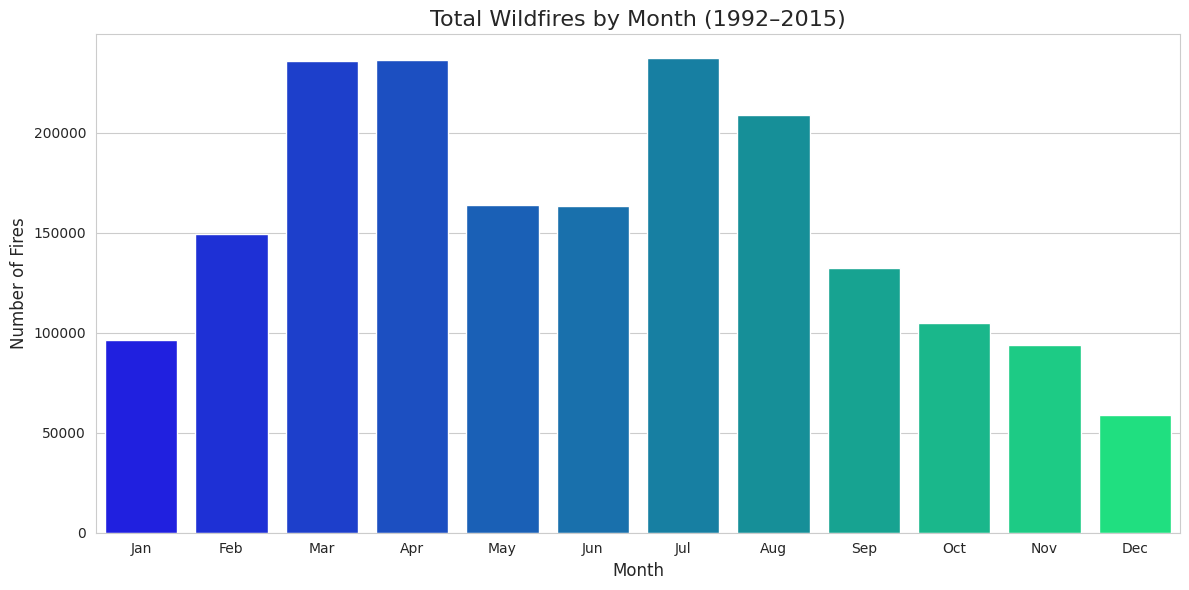

In [7]:
# --- Creating Correct DISCOVERY_DATETIME and MONTH Feature ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if "DISCOVERY_DATE" not in df.columns:
    raise ValueError("DISCOVERY_DATE column is missing from df!")

# Convert Julian day to datetime
df["DISCOVERY_DATETIME"] = pd.to_datetime(
    df["DISCOVERY_DATE"], unit="D", origin="julian"
)

# Extract month
df["MONTH"] = df["DISCOVERY_DATETIME"].dt.month

print("--- Correct 'DATETIME' and 'MONTH' Features Created ---")
display(df[["DISCOVERY_DATETIME", "MONTH"]].head())

# --- Plot Wildfires by Month ---
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x="MONTH",
    palette="winter",
    hue="MONTH",
    legend=False
)

plt.title("Total Wildfires by Month (1992–2015)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Fires", fontsize=12)
plt.xticks(
    ticks=range(12),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.tight_layout()
plt.show()


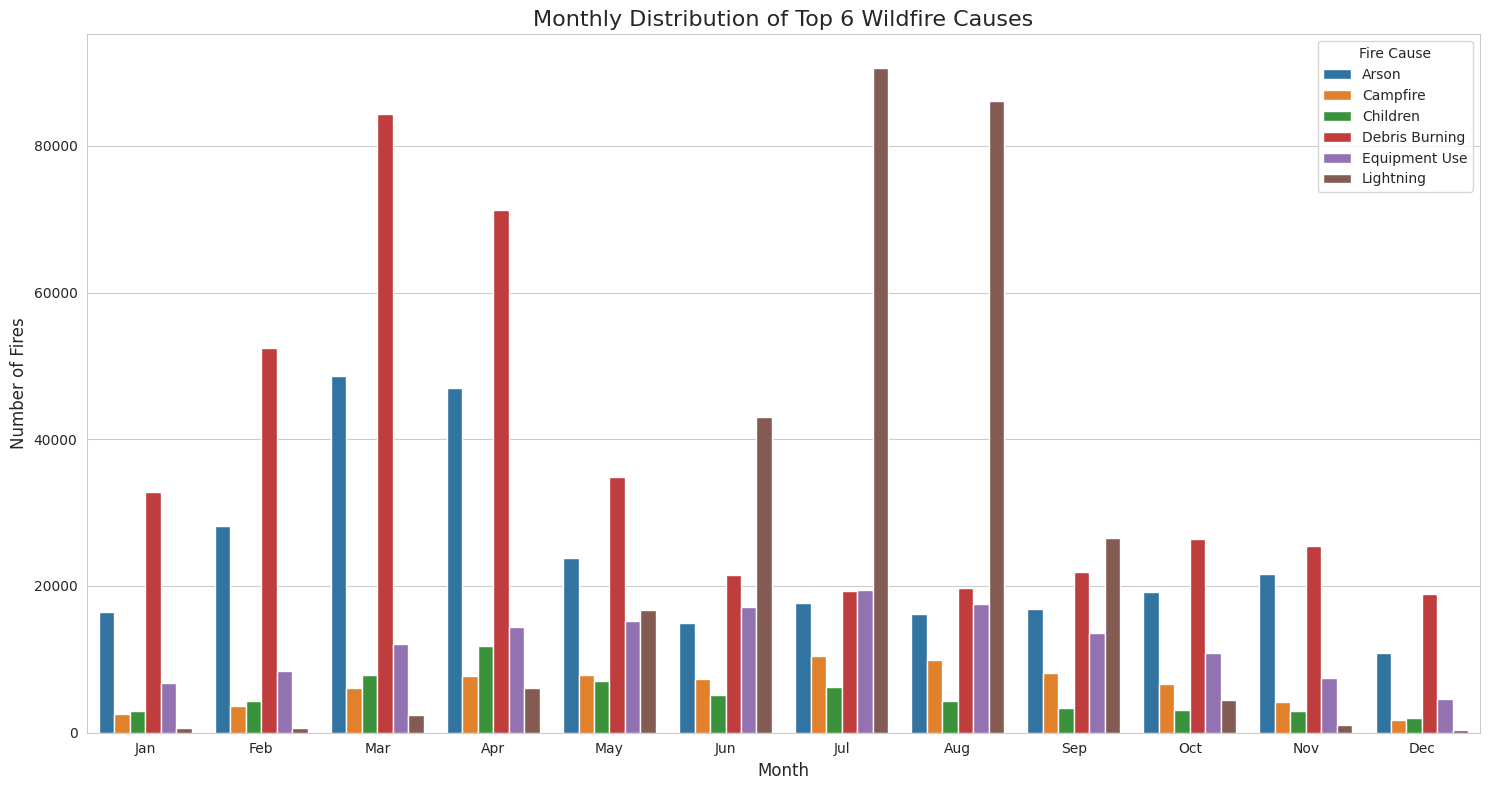

In [8]:
# --- Monthly Distribution of Top 6 Wildfire Causes ---

import matplotlib.pyplot as plt
import seaborn as sns

top_causes = [
    "Debris Burning", "Arson", "Lightning",
    "Equipment Use", "Campfire", "Children"
]

if "STAT_CAUSE_DESCR" not in df.columns:
    raise ValueError("STAT_CAUSE_DESCR column is missing from df!")

# Filter only top causes
df_top_causes = df[df["STAT_CAUSE_DESCR"].isin(top_causes)].copy()

# Ensure column is categorical to remove unused categories
if df_top_causes["STAT_CAUSE_DESCR"].dtype != "category":
    df_top_causes["STAT_CAUSE_DESCR"] = df_top_causes["STAT_CAUSE_DESCR"].astype("category")

df_top_causes["STAT_CAUSE_DESCR"] = df_top_causes["STAT_CAUSE_DESCR"].cat.remove_unused_categories()

# Plot
plt.figure(figsize=(15, 8))
sns.countplot(
    data=df_top_causes,
    x="MONTH",
    hue="STAT_CAUSE_DESCR",
    palette="tab10"
)

plt.title("Monthly Distribution of Top 6 Wildfire Causes", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Fires", fontsize=12)
plt.xticks(
    ticks=range(12),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.legend(title="Fire Cause")
plt.tight_layout()
plt.show()


Select Relevant Columns

In [9]:
cols = [
    "FIRE_YEAR",
    "DISCOVERY_DOY",
    "DISCOVERY_DATE",
    "LATITUDE",
    "LONGITUDE",
    "STATE",
    "STAT_CAUSE_DESCR",  # <--- THIS IS THE NEW TARGET VARIABLE
    "FIRE_SIZE",         # Optional: Keep for EDA, but drop before training
]

df = df_raw[cols].copy()
print("Selected columns:", df.columns.tolist())
print("Shape:", df.shape)
df.info()

Selected columns: ['FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_DATE', 'LATITUDE', 'LONGITUDE', 'STATE', 'STAT_CAUSE_DESCR', 'FIRE_SIZE']
Shape: (1880465, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FIRE_YEAR         int64  
 1   DISCOVERY_DOY     int64  
 2   DISCOVERY_DATE    float64
 3   LATITUDE          float64
 4   LONGITUDE         float64
 5   STATE             object 
 6   STAT_CAUSE_DESCR  object 
 7   FIRE_SIZE         float64
dtypes: float64(4), int64(2), object(2)
memory usage: 114.8+ MB


Basic EDA

/tmp/ipython-input-1663464892.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cause_counts.index, y=cause_counts.values, palette='viridis')


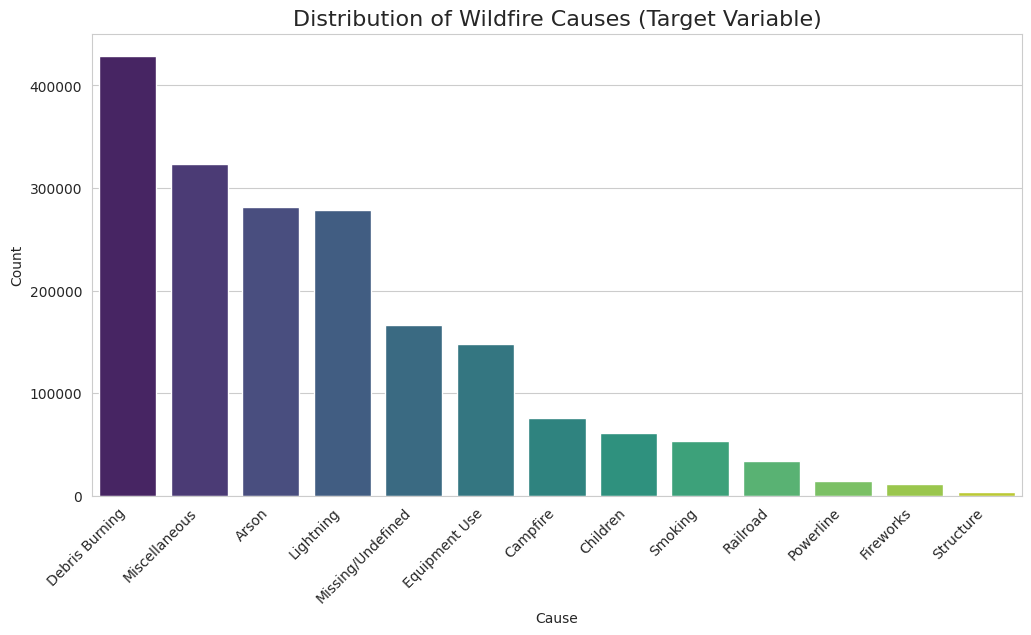

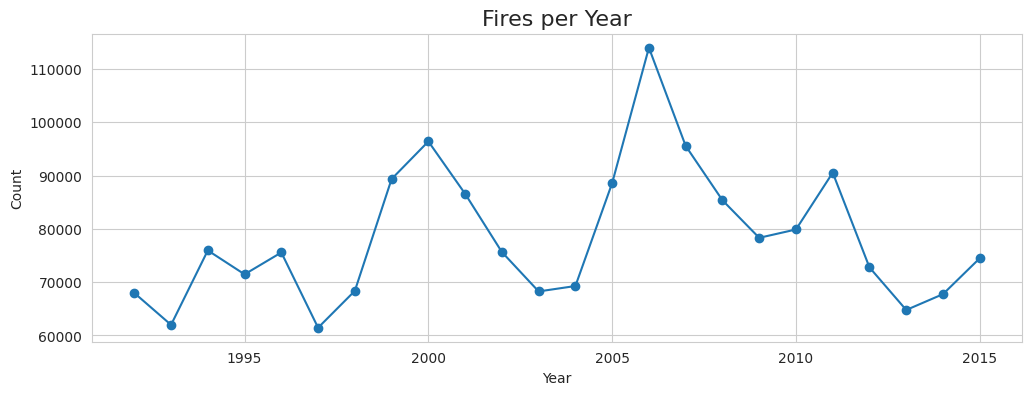

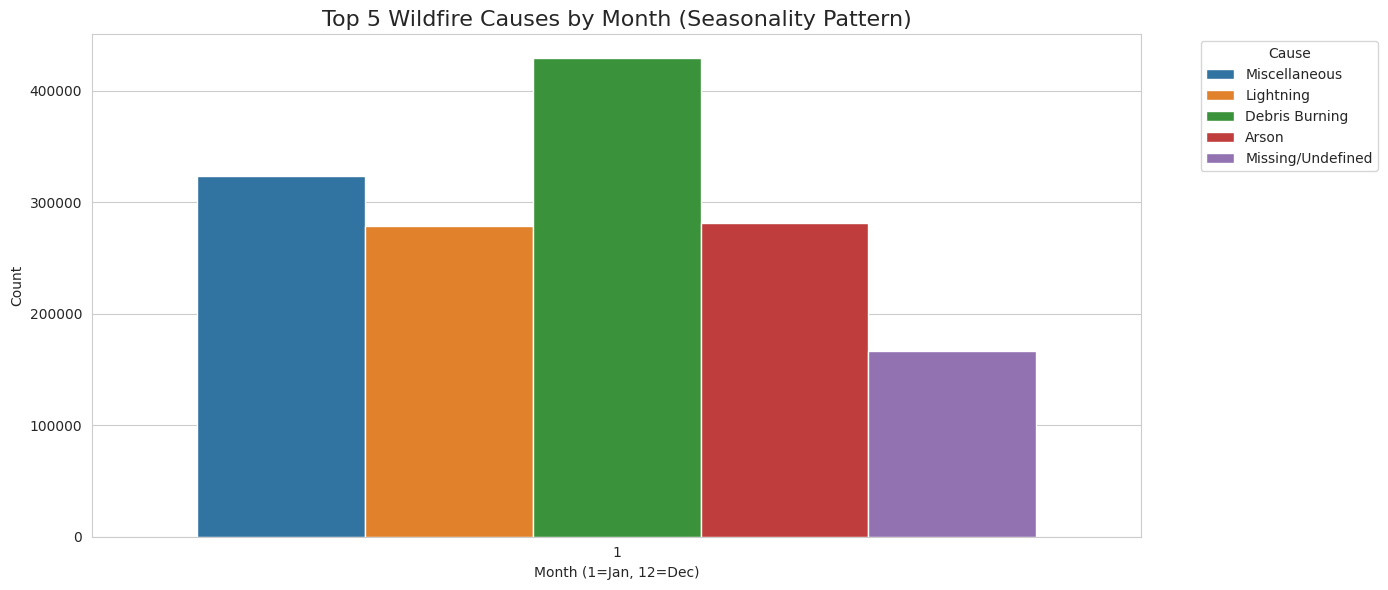

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Re-create the Missing 'MONTH' Feature ---
# Ensure date is in datetime format
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce')
# Extract Month
df['MONTH'] = df['DISCOVERY_DATE'].dt.month

# Set visual style
sns.set_style("whitegrid")

# --- 2. Plot 1: Distribution of Fire Causes ---
plt.figure(figsize=(12, 6))
cause_counts = df['STAT_CAUSE_DESCR'].value_counts()
sns.barplot(x=cause_counts.index, y=cause_counts.values, palette='viridis')
plt.title("Distribution of Wildfire Causes (Target Variable)", fontsize=16)
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- 3. Plot 2: Fires per Year ---
plt.figure(figsize=(12, 4))
df["FIRE_YEAR"].value_counts().sort_index().plot(kind='line', marker='o')
plt.title("Fires per Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# --- 4. Plot 3: Seasonality of Causes ---
plt.figure(figsize=(14, 6))

# Filter to top 5 causes so the chart is readable
top_causes = df['STAT_CAUSE_DESCR'].value_counts().nlargest(5).index
df_top = df[df['STAT_CAUSE_DESCR'].isin(top_causes)]

sns.countplot(data=df_top, x='MONTH', hue='STAT_CAUSE_DESCR', palette='tab10')
plt.title("Top 5 Wildfire Causes by Month (Seasonality Pattern)", fontsize=16)
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Count")
plt.legend(title="Cause", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Datetime Feature Engineering

In [11]:
import pandas as pd
import numpy as np

# 1. Convert Julian Date to standard Timestamp (Safely)
# Check if it is already datetime to avoid the TypeError
if not pd.api.types.is_datetime64_any_dtype(df['DISCOVERY_DATE']):
    df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], origin='julian', unit='D')

# 2. Extract temporal features
df['MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DAY_OF_YEAR'] = df['DISCOVERY_DATE'].dt.dayofyear
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.dayofweek

# 3. Create Season (Northern Hemisphere)
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['SEASON'] = df['MONTH'].map(season_map)

# Verify the results
print(df[['DISCOVERY_DATE', 'MONTH', 'DAY_OF_YEAR', 'SEASON']].head())

                 DISCOVERY_DATE  MONTH  DAY_OF_YEAR  SEASON
0 1970-01-01 00:00:00.002453403      1            1  Winter
1 1970-01-01 00:00:00.002453137      1            1  Winter
2 1970-01-01 00:00:00.002453156      1            1  Winter
3 1970-01-01 00:00:00.002453184      1            1  Winter
4 1970-01-01 00:00:00.002453184      1            1  Winter


Geo Cluster Feature

In [12]:
from sklearn.cluster import KMeans

# 1. Select Coordinates
coords = df[["LATITUDE", "LONGITUDE"]].dropna()

# 2. Create Geo Clusters (Increased to 30 for better granularity)
# A higher number helps separate distinct biomes (e.g., Coast vs. Inland Valley vs. Mountains)
kmeans = KMeans(n_clusters=30, random_state=42)
geo_labels = kmeans.fit_predict(coords)

# 3. Assign Labels back to the main DataFrame
df.loc[coords.index, "GEO_CLUSTER"] = geo_labels

# 4. Handle any missing values (though dropna() above should prevent this)
df["GEO_CLUSTER"] = df["GEO_CLUSTER"].fillna(-1).astype(int)

# Verify
print("Geo Clusters Created:", df["GEO_CLUSTER"].nunique())
df[["LATITUDE", "LONGITUDE", "GEO_CLUSTER"]].head()

Geo Clusters Created: 30


,LATITUDE,LONGITUDE,GEO_CLUSTER
0,40.036944,-121.005833,22
1,38.933056,-120.404444,1
2,38.984167,-120.735556,1
3,38.559167,-119.913333,1
4,38.559167,-119.933056,1


from matplotlib import pyplot as plt
_df_2['LATITUDE'].plot(kind='hist', bins=20, title='LATITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['LONGITUDE'].plot(kind='hist', bins=20, title='LONGITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['GEO_CLUSTER'].plot(kind='hist', bins=20, title='GEO_CLUSTER')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='LATITUDE', y='LONGITUDE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='LONGITUDE', y='GEO_CLUSTER', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['LATITUDE'].plot(kind='line', figsize=(8, 4), title='LATITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['LONGITUDE'].plot(kind='line', figsize=(8, 4), title='LONGITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['GEO_CLUSTER'].plot(kind='line', figsize=(8, 4), title='GEO_CLUSTER')
plt.gca().spines[['top', 'right']].set_visible(False)

Drop Unusable Columns & NaNs

In [13]:
df = df.drop(columns=["DISCOVERY_DATE"])  # datetime not directly used by model

df = df.dropna()
print("After dropna shape:", df.shape)
df.head()


After dropna shape: (1880465, 12)


,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,STATE,STAT_CAUSE_DESCR,FIRE_SIZE,MONTH,DAY_OF_YEAR,DAY_OF_WEEK,SEASON,GEO_CLUSTER
0,2005,33,40.036944,-121.005833,CA,Miscellaneous,0.10,1,1,3,Winter,22
1,2004,133,38.933056,-120.404444,CA,Lightning,0.25,1,1,3,Winter,1
2,2004,152,38.984167,-120.735556,CA,Debris Burning,0.10,1,1,3,Winter,1
3,2004,180,38.559167,-119.913333,CA,Lightning,0.10,1,1,3,Winter,1
4,2004,180,38.559167,-119.933056,CA,Lightning,0.10,1,1,3,Winter,1


from matplotlib import pyplot as plt
_df_10['FIRE_YEAR'].plot(kind='hist', bins=20, title='FIRE_YEAR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['DISCOVERY_DOY'].plot(kind='hist', bins=20, title='DISCOVERY_DOY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['LATITUDE'].plot(kind='hist', bins=20, title='LATITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['LONGITUDE'].plot(kind='hist', bins=20, title='LONGITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_14.groupby('STAT_CAUSE_DESCR').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15.plot(kind='scatter', x='FIRE_YEAR', y='DISCOVERY_DOY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='DISCOVERY_DOY', y='LATITUDE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='LATITUDE', y='LONGITUDE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='LONGITUDE', y='FIRE_SIZE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DISCOVERY_DOY']
  ys = series['FIRE_YEAR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_19.sort_values('DISCOVERY_DOY', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('STAT_CAUSE_DESCR')):
  _plot_series(series, series_name, i)
  fig.legend(title='STAT_CAUSE_DESCR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DISCOVERY_DOY')
_ = plt.ylabel('FIRE_YEAR')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DISCOVERY_DOY']
  ys = series['LATITUDE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_20.sort_values('DISCOVERY_DOY', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('STAT_CAUSE_DESCR')):
  _plot_series(series, series_name, i)
  fig.legend(title='STAT_CAUSE_DESCR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DISCOVERY_DOY')
_ = plt.ylabel('LATITUDE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DISCOVERY_DOY']
  ys = series['LONGITUDE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('DISCOVERY_DOY', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('STAT_CAUSE_DESCR')):
  _plot_series(series, series_name, i)
  fig.legend(title='STAT_CAUSE_DESCR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DISCOVERY_DOY')
_ = plt.ylabel('LONGITUDE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DISCOVERY_DOY']
  ys = series['FIRE_SIZE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('DISCOVERY_DOY', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('STAT_CAUSE_DESCR')):
  _plot_series(series, series_name, i)
  fig.legend(title='STAT_CAUSE_DESCR', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DISCOVERY_DOY')
_ = plt.ylabel('FIRE_SIZE')

from matplotlib import pyplot as plt
_df_23['FIRE_YEAR'].plot(kind='line', figsize=(8, 4), title='FIRE_YEAR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_24['DISCOVERY_DOY'].plot(kind='line', figsize=(8, 4), title='DISCOVERY_DOY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_25['LATITUDE'].plot(kind='line', figsize=(8, 4), title='LATITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['LONGITUDE'].plot(kind='line', figsize=(8, 4), title='LONGITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['STAT_CAUSE_DESCR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='FIRE_YEAR', y='STAT_CAUSE_DESCR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['STAT_CAUSE_DESCR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='DISCOVERY_DOY', y='STAT_CAUSE_DESCR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['STAT_CAUSE_DESCR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='LATITUDE', y='STAT_CAUSE_DESCR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_30['STAT_CAUSE_DESCR'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_30, x='LONGITUDE', y='STAT_CAUSE_DESCR', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Encode Categorical Features

In [14]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

# Updated list: Removed "FIRE_SIZE_CLASS"
cat_cols = ["STATE", "SEASON"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("Encoded columns:", cat_cols)
df[cat_cols].head()

Encoded columns: ['STATE', 'SEASON']


,STATE,SEASON
0,4,0
1,4,0
2,4,0
3,4,0
4,4,0


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['STATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'STATE'}, axis=1)
              .sort_values('STATE', ascending=True))
  xs = counted['STATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('STATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('STATE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SEASON']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SEASON'}, axis=1)
              .sort_values('SEASON', ascending=True))
  xs = counted['SEASON']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('SEASON', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SEASON')
_ = plt.ylabel('count()')

Define Features & Target, Split Data

In [15]:
from sklearn.preprocessing import LabelEncoder

# 1. Define the New Target (Cause)
target = "STAT_CAUSE_DESCR"

# 2. Define Features (X)
# Critical: Drop 'FIRE_SIZE' to prevent data leakage.
# We also drop 'DISCOVERY_DATE' if it's still there (we use the numeric features instead).
drop_cols = [target, "FIRE_SIZE", "DISCOVERY_DATE"]

# Use 'errors=ignore' just in case a column was already dropped
X = df.drop(columns=drop_cols, errors='ignore')

# 3. Encode the Target (y)
# Convert text labels ("Arson", "Lightning") into numbers (0, 1)
le_target = LabelEncoder()
y = le_target.fit_transform(df[target])

# Print feature list to confirm FIRE_SIZE is gone
print(f"Target: {target}")
print(f"Features used: {X.columns.tolist()}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y  # Crucial for imbalanced classes like Arson/Lightning
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Target: STAT_CAUSE_DESCR
Features used: ['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'STATE', 'MONTH', 'DAY_OF_YEAR', 'DAY_OF_WEEK', 'SEASON', 'GEO_CLUSTER']
X shape: (1880465, 10), y shape: (1880465,)
Train shape: (1504372, 10) Test shape: (376093, 10)


Balance with SMOTE




Original Dataset Shape: Counter({np.int64(3): 343222, np.int64(7): 259044, np.int64(0): 225164, np.int64(6): 222775, np.int64(8): 133378, np.int64(4): 118090, np.int64(1): 60911, np.int64(2): 48934, np.int64(11): 42295, np.int64(10): 26764, np.int64(9): 11558, np.int64(5): 9200, np.int64(12): 3037})
Resampled Dataset Shape: Counter({np.int64(11): 343222, np.int64(8): 343222, np.int64(7): 343222, np.int64(6): 343222, np.int64(4): 343222, np.int64(10): 343222, np.int64(1): 343222, np.int64(3): 343222, np.int64(0): 343222, np.int64(9): 343222, np.int64(12): 343222, np.int64(2): 343222, np.int64(5): 343222})

Before SMOTE: (1504372, 10)
After SMOTE: (4461886, 10)


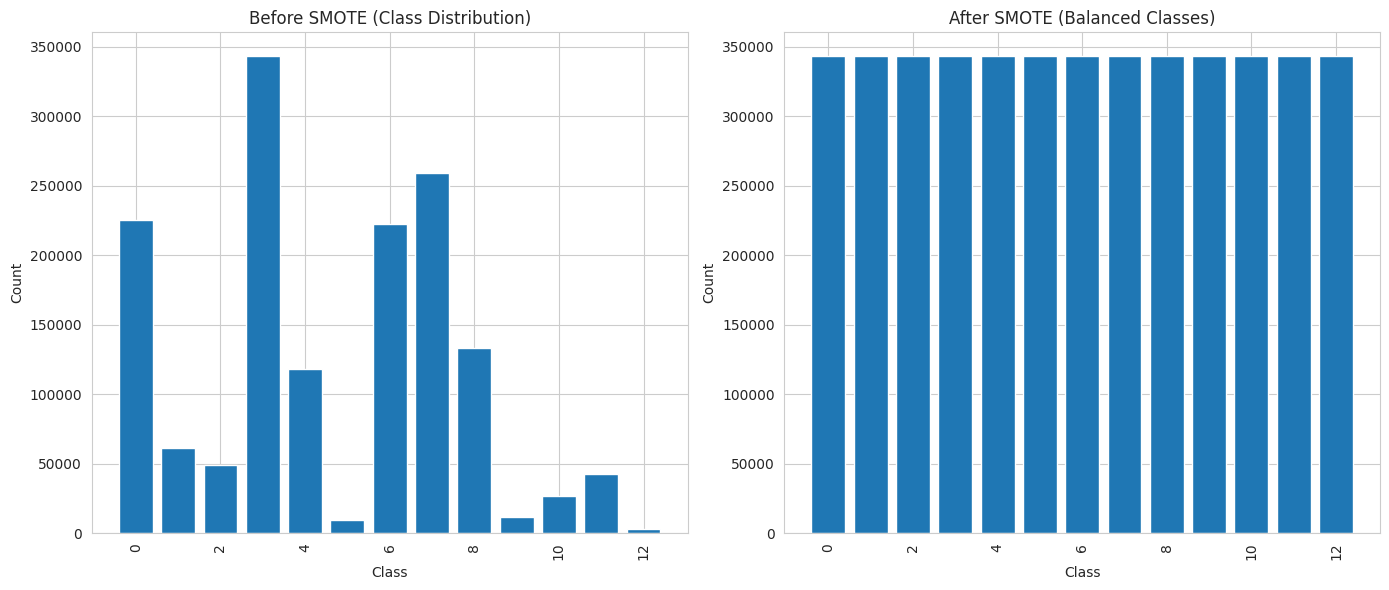

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# ---------------------------
# 1. Apply SMOTE
# ---------------------------
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ---------------------------
# 2. Print class distribution
# ---------------------------
print("Original Dataset Shape:", Counter(y_train))
print("Resampled Dataset Shape:", Counter(y_train_resampled))

print("\nBefore SMOTE:", X_train.shape)
print("After SMOTE:", X_train_resampled.shape)

# ---------------------------
# 3. Graph: Before vs After SMOTE
# ---------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Before SMOTE ---
axes[0].bar(Counter(y_train).keys(), Counter(y_train).values())
axes[0].set_title("Before SMOTE (Class Distribution)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)

# --- After SMOTE ---
axes[1].bar(Counter(y_train_resampled).keys(), Counter(y_train_resampled).values())
axes[1].set_title("After SMOTE (Balanced Classes)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# --- 1. Define Preprocessing Steps ---
print("--- Building and Training Pipeline ---")
categorical_features = ['STATE']
numerical_features = ['LATITUDE', 'LONGITUDE', 'MONTH']

# Create a preprocessor to handle different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- 2. Create the Full Machine Learning Pipeline ---
# This is where 'pipeline' is defined
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='saga', random_state=42, n_jobs=-1))
                          ])

# --- 3. Train the Model ---
print("Training the Logistic Regression model...")
# This .fit() command trains the pipeline on your training data
pipeline.fit(X_train, y_train)

print("\nModel training complete!")

--- Building and Training Pipeline ---
Training the Logistic Regression model...

Model training complete!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Making predictions on the test set...

Model Accuracy: 42.56%

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

         Arson       0.41      0.30      0.34     56291
      Campfire       0.00      0.00      0.00     15228
      Children       0.00      0.00      0.00     12233
Debris Burning       0.42      0.71      0.53     85806
 Equipment Use       0.24      0.00      0.00     29522
     Fireworks       0.00      0.00      0.00      2300
     Lightning       0.50      0.75      0.60     55694
 Miscellaneous       0.38      0.39      0.38     64761
     Powerline       0.00      0.00      0.00      2890
      Railroad       0.25      0.19      0.22      6691
       Smoking       0.00      0.00      0.00     10574
     Structure       0.00      0.00      0.00       759

      accuracy                           0.43    342749
     macro avg       0.18      0.19      0.17    342749
  weighted avg       0.35      0.43      0.36    342749


Generating Confusion Matrix...


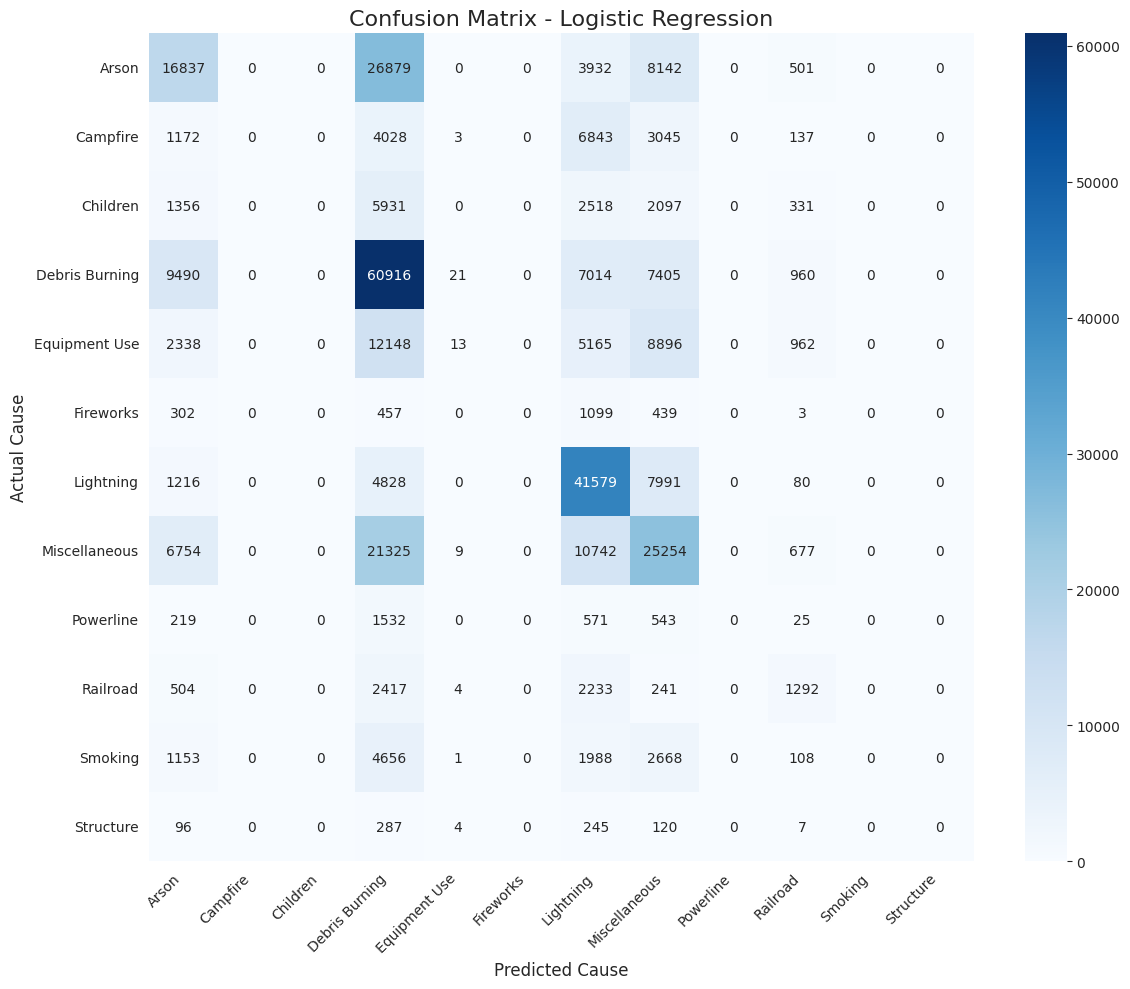

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Making predictions on the test set...")
# Use the trained pipeline to predict on the test data
y_pred = pipeline.predict(X_test)

# --- 1. Calculate Accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# --- 2. Print Classification Report ---
# This gives precision, recall, and f1-score for each cause
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 3. Plot Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted Cause', fontsize=12)
plt.ylabel('Actual Cause', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from cuml.ensemble import RandomForestClassifier as cuRF  # Import the GPU version
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# --- 1. Define Preprocessing Steps ---
print("--- Building Pipeline for GPU Random Forest (Corrected) ---")
categorical_features = ['STATE']
numerical_features = ['LATITUDE', 'LONGITUDE', 'MONTH']

# The sklearn preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        # --- FIX IS HERE: add sparse_output=False ---
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# --- 2. Convert y labels (already done, but we'll re-define) ---
print("Converting labels to int32 format for cuML...")
y_train_gpu = y_train.cat.codes.astype(np.int32)
y_test_gpu = y_test.cat.codes.astype(np.int32)
class_names = y_train.cat.categories


# --- 3. Create the Full Machine Learning Pipeline ---
rf_pipeline_gpu = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', cuRF(random_state=42))
                                 ])

# --- 4. Train the Model on the GPU ---
print("Training the GPU Random Forest model...")
rf_pipeline_gpu.fit(X_train, y_train_gpu)

print("\nRandom Forest model (GPU) training complete!")

# --- 5. Evaluate the Random Forest Model ---
print("Making predictions on the test set with GPU Random Forest...")
y_pred_rf_gpu = rf_pipeline_gpu.predict(X_test)

# Calculate and print the new accuracy
accuracy_rf_gpu = accuracy_score(y_test_gpu, y_pred_rf_gpu)
print(f"\nRandom Forest Model (GPU) Accuracy: {accuracy_rf_gpu * 100:.2f}%")

# Print the full classification report
print("\nRandom Forest (GPU) Classification Report:")
print(classification_report(y_test_gpu, y_pred_rf_gpu, target_names=class_names))

--- Building Pipeline for GPU Random Forest (Corrected) ---
Converting labels to int32 format for cuML...
Training the GPU Random Forest model...

Random Forest model (GPU) training complete!
Making predictions on the test set with GPU Random Forest...

Random Forest Model (GPU) Accuracy: 43.21%

Random Forest (GPU) Classification Report:
                precision    recall  f1-score   support

         Arson       0.44      0.24      0.31     56291
      Campfire       0.00      0.00      0.00     15228
      Children       0.00      0.00      0.00     12233
Debris Burning       0.40      0.79      0.53     85806
 Equipment Use       0.00      0.00      0.00     29522
     Fireworks       0.00      0.00      0.00      2300
     Lightning       0.53      0.76      0.62     55694
 Miscellaneous       0.39      0.38      0.38     64761
     Powerline       0.00      0.00      0.00      2890
      Railroad       0.00      0.00      0.00      6691
       Smoking       0.00      0.00      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train XGBoost with Hyperparameter Tuning

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. Define Hyperparameter Grid
params = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [4, 6, 10],
    "n_estimators": [100, 200, 300], # Slightly reduced upper limit to save time
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 1.0],  # Added: helps prevent overfitting
}

# 2. Define the Model
# We use len(le_target.classes_) to get the exact number of Fire Causes
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(le_target.classes_),
    tree_method="hist",  # Faster training
    eval_metric="mlogloss",
    random_state=42
)

# 3. Set up Search
search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    n_iter=5,            # 5 candidates
    scoring="accuracy",  # "f1_macro" is also good for imbalanced data
    cv=2,                # 2-fold cross-validation to save time
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Fit (This may take a few minutes)
print("Starting Hyperparameter Tuning...")
search.fit(X_train_res, y_train_res)
best_model = search.best_estimator_

print("\nBest parameters found:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

Starting Hyperparameter Tuning...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV Accuracy: 0.6188667751708583


Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Predict on Test Data
y_pred = best_model.predict(X_test)

# 2. Print Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 3. Print Classification Report with Actual Class Names
# target_names argument maps 0 -> 'Arson', 1 -> 'Campfire', etc.
print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=le_target.classes_
))

Accuracy: 0.4984777701260061

Classification Report:

                   precision    recall  f1-score   support

            Arson       0.55      0.51      0.53     56291
         Campfire       0.31      0.49      0.38     15228
         Children       0.18      0.33      0.23     12233
   Debris Burning       0.60      0.40      0.48     85806
    Equipment Use       0.33      0.34      0.33     29522
        Fireworks       0.22      0.72      0.33      2300
        Lightning       0.80      0.76      0.78     55693
    Miscellaneous       0.61      0.34      0.44     64761
Missing/Undefined       0.80      0.87      0.84     33345
        Powerline       0.08      0.50      0.14      2890
         Railroad       0.31      0.63      0.41      6691
          Smoking       0.12      0.21      0.15     10574
        Structure       0.03      0.38      0.06       759

         accuracy                           0.50    376093
        macro avg       0.38      0.50      0.39    376093


Save Model & Encoders

In [ ]:
import joblib
import os

# Define paths
BASE_PATH = "/content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/app/cause_model/cause_"
MODEL_PATH = f"{BASE_PATH}xgb_model.pkl"
ENC_PATH = f"{BASE_PATH}encoders.pkl"

# 1. Create directory if it doesn't exist
os.makedirs(BASE_PATH, exist_ok=True)

# 2. Add the Target Encoder to the encoders dictionary
# We need this later to translate numbers back into text (e.g. 0 -> 'Lightning')
encoders['target_encoder'] = le_target

# 3. Save the Model and Encoders
print(f"Saving model to {MODEL_PATH}...")
joblib.dump(best_model, MODEL_PATH)

print(f"Saving encoders to {ENC_PATH}...")
joblib.dump(encoders, ENC_PATH)

print(" Save complete!")

Saving model to /content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/app/cause_model/cause_xgb_model.pkl...
Saving encoders to /content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/app/cause_model/cause_encoders.pkl...
 Save complete!


Load Model & Enhanced Inference

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Define paths (Make sure these match where you saved them!)
MODEL_PATH = "/content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/app/cause_model/cause_xgb_model.pkl"
ENC_PATH = "/content/drive/MyDrive/karthik/Shashank_project_DSA/wildfire-project/app/cause_model/cause_encoders.pkl"

print("Loading model and encoders...")

try:
    # 1. Load the files
    loaded_model = joblib.load(MODEL_PATH)
    loaded_encoders = joblib.load(ENC_PATH)

    # 2. Extract the Target Encoder (Cause Labels)
    # We stored this as 'target_encoder' in the save step.
    # We pop it so 'loaded_encoders' only contains feature encoders (like STATE, SEASON).
    target_le = loaded_encoders.pop('target_encoder')

    print("Model loaded successfully!")
    print(f"Feature Encoders loaded: {list(loaded_encoders.keys())}")
    print(f"Target Classes loaded: {target_le.classes_}")

except FileNotFoundError:
    print(" Error: Files not found. Did you run the SAVE cell in the previous step?")

Loading model and encoders...
Model loaded successfully!
Feature Encoders loaded: ['STATE', 'SEASON']
Target Classes loaded: ['Arson' 'Campfire' 'Children' 'Debris Burning' 'Equipment Use'
 'Fireworks' 'Lightning' 'Miscellaneous' 'Missing/Undefined' 'Powerline'
 'Railroad' 'Smoking' 'Structure']


Test Inference

In [ ]:
def predict_wildfire_cause(input_data: dict):
    """
    Accepts a dictionary of fire conditions and predicts the likely cause.
    Expected keys: FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_DATE, LATITUDE, LONGITUDE, STATE
    """
    print("\n--- Predicting Fire Cause ---")

    # 1. Convert Input Dictionary to DataFrame
    input_df = pd.DataFrame([input_data])

    # 2. DateTime Processing (Crucial for Seasonality)
    # We must replicate the exact logic used in training
    if 'DISCOVERY_DATE' in input_df.columns:
        input_df['DISCOVERY_DATE'] = pd.to_datetime(input_df['DISCOVERY_DATE'], origin='julian', unit='D')
        input_df['MONTH'] = input_df['DISCOVERY_DATE'].dt.month
        input_df['DAY_OF_YEAR'] = input_df['DISCOVERY_DATE'].dt.dayofyear
        input_df['DAY_OF_WEEK'] = input_df['DISCOVERY_DATE'].dt.dayofweek

        # Map Season
        season_map = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Fall', 10:'Fall', 11:'Fall'
        }
        input_df['SEASON'] = input_df['MONTH'].map(season_map)

    # 3. Geo Clustering (Simplified for Inference)
    # In a full prod app, you would load the KMeans model.
    # Here we approximate it or set to -1 to avoid errors if missing.
    input_df["GEO_CLUSTER"] = -1

    # 4. Apply Feature Encoders (Safely)
    for col, encoder in loaded_encoders.items():
        if col in input_df.columns:
            # Handle unseen labels (e.g., a State the model hasn't seen) by assigning a default
            input_df[col] = input_df[col].astype(str).map(
                lambda s: encoder.transform([s])[0] if s in encoder.classes_ else 0
            )

    # 5. Drop Unused Columns & Align Features
    # The model expects specific columns in a specific order.
    expected_features = loaded_model.get_booster().feature_names

    # Ensure all expected columns exist (fill 0 if missing)
    for col in expected_features:
        if col not in input_df.columns:
            input_df[col] = 0

    # Select only the columns the model knows
    final_X = input_df[expected_features]

    # 6. Predict
    pred_id = int(loaded_model.predict(final_X)[0])
    pred_prob = np.max(loaded_model.predict_proba(final_X)[0])

    # 7. Decode Label (Integer -> Human Readable String)
    cause_name = target_le.inverse_transform([pred_id])[0]

    return {
        "Predicted Cause": cause_name,
        "Confidence": f"{pred_prob:.2%}",
        "Input Context": f"State: {input_data.get('STATE')}, Month: {input_df['MONTH'].iloc[0]}"
    }

# --- Test Case ---
test_fire = {
    "FIRE_YEAR": 2024,
    "DISCOVERY_DOY": 200,       # July (Summer)
    "DISCOVERY_DATE": 2460500,  # Julian Date Example
    "LATITUDE": 39.0,           # California/Nevada border
    "LONGITUDE": -120.0,
    "STATE": "CA"
}

# Run Prediction
try:
    result = predict_wildfire_cause(test_fire)
    print("\n PREDICTION RESULT ")
    print(result)
except Exception as e:
    print(f"Prediction failed: {e}")


--- Predicting Fire Cause ---

 PREDICTION RESULT 
{'Predicted Cause': 'Lightning', 'Confidence': '62.53%', 'Input Context': 'State: CA, Month: 7'}
